Importing Modules

In [47]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input



Loading the dataset from kaggle

In [48]:
BASE_DIR = '../input/utkface/UTKFace/'

In [49]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [50]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()


,image,age,gender
0,../input/utkface/UTKFace/26_0_2_20170104023102...,26,0
1,../input/utkface/UTKFace/22_1_1_20170112233644...,22,1
2,../input/utkface/UTKFace/21_1_3_20170105003215...,21,1
3,../input/utkface/UTKFace/28_0_0_20170117180555...,28,0
4,../input/utkface/UTKFace/17_1_4_20170103222931...,17,1


In [51]:
# map labels for gender
gender_dict = {0: 'Male', 1: 'Female'}


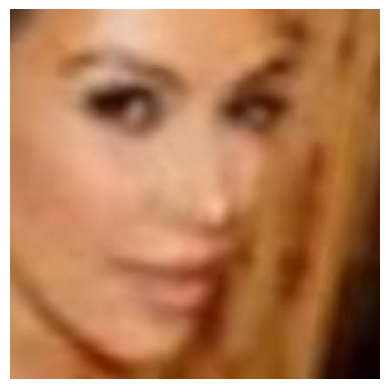

In [52]:
from PIL import Image
img = Image.open(df['image'][13])
plt.axis('off')
plt.imshow(img);


<Axes: xlabel='age', ylabel='Density'>

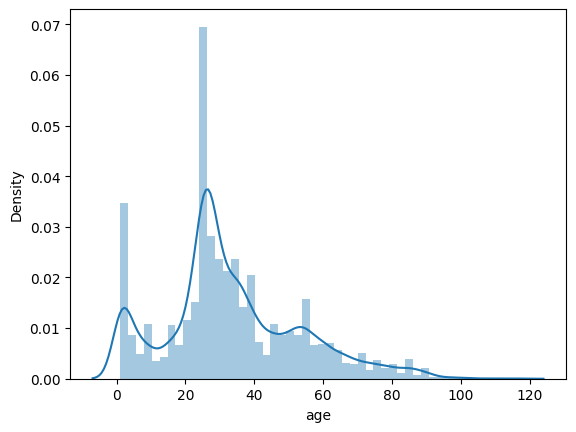

In [53]:
sns.distplot(df['age'])

<Axes: xlabel='gender', ylabel='Density'>

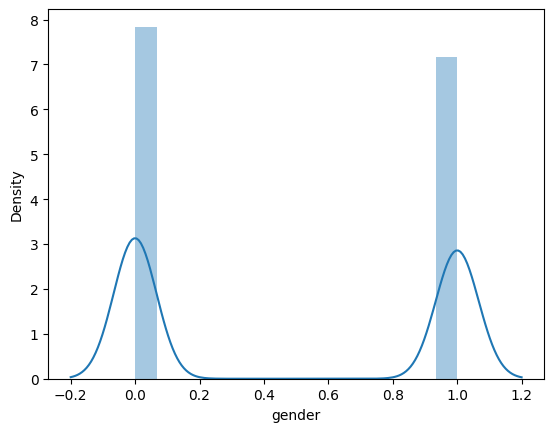

In [54]:
sns.distplot(df['gender'])

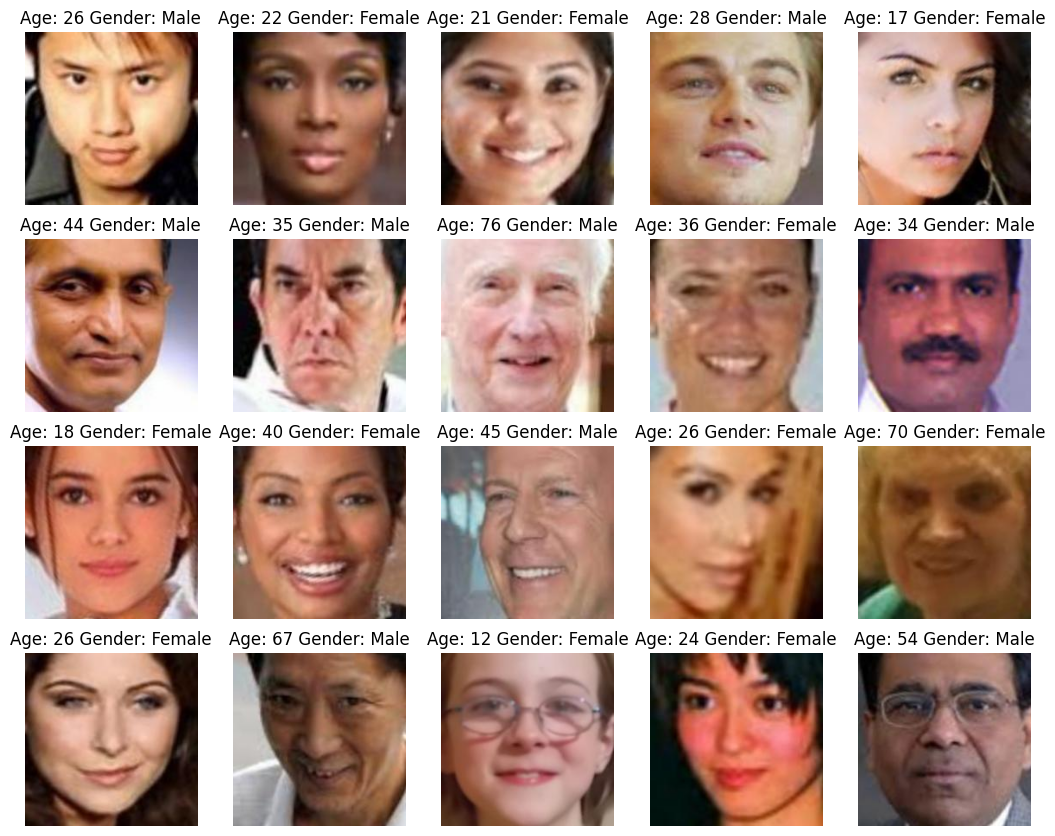

In [55]:
# to display grid of images
plt.figure(figsize=(13, 13))
files = df.iloc[0:20]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


In [56]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [57]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [58]:
X.shape

(23708, 128, 128, 1)

In [59]:
# normalize the images
X = X / 255.0


In [60]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])


In [61]:
input_shape = (128, 128, 1)



Model


In [62]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)
# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [63]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 126, 126, 32)   │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 63, 63, 32)     │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 30, 30, 64)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 14, 14, 128)    │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 12, 12, 256)    │        295,168 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 6, 6, 256)      │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 9216)           │              0 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │      2,359,552 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │      2,359,552 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 256)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 256)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_out (Dense)        │ (None, 1)              │            257 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_out (Dense)           │ (None, 1)              │            257 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

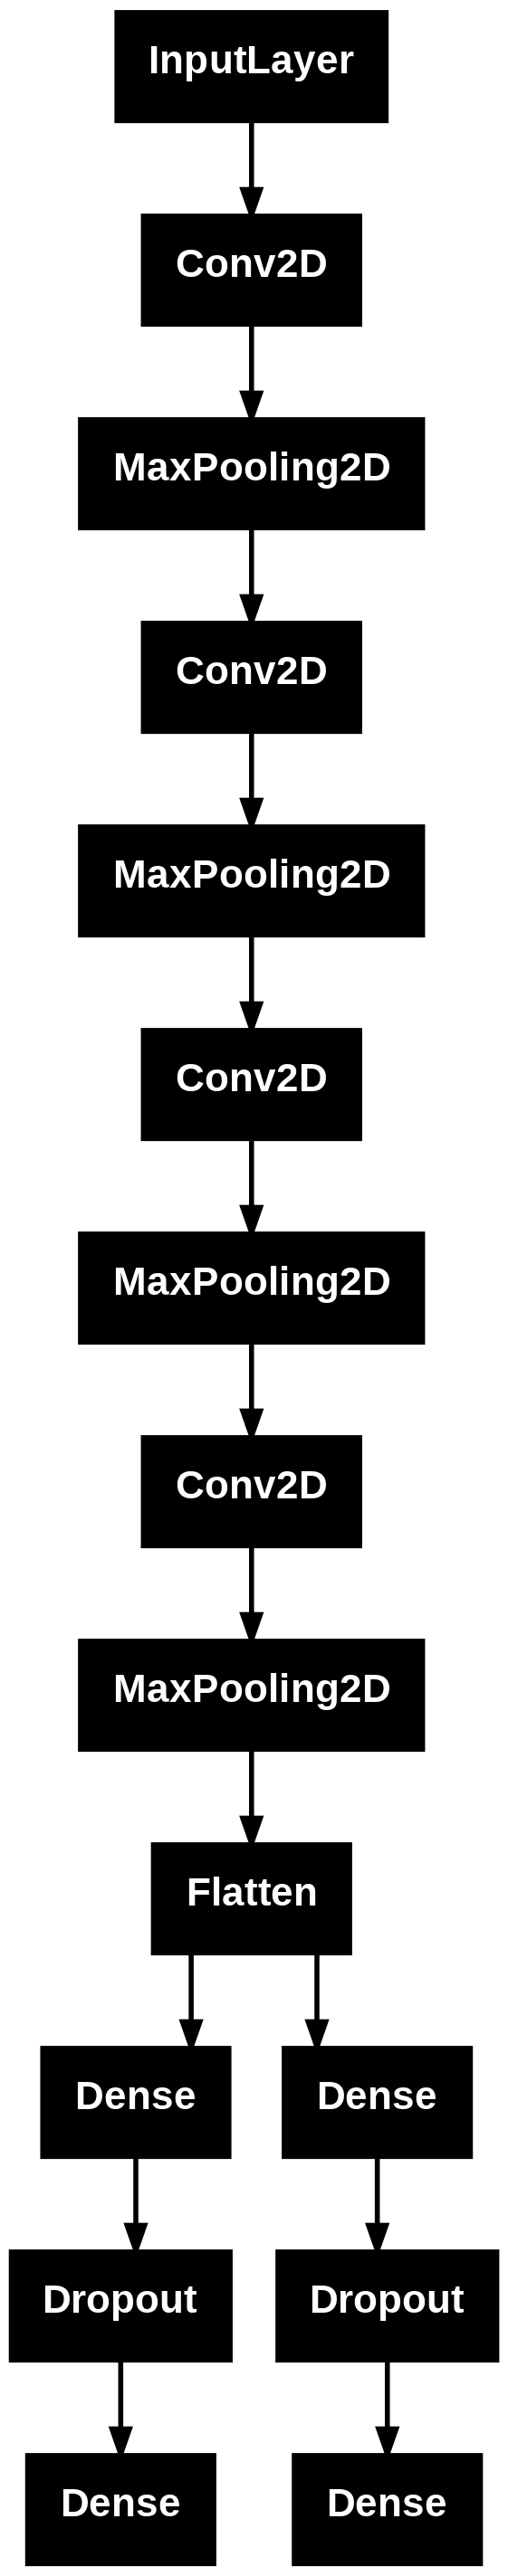

In [64]:
from tensorflow.keras.utils import plot_model

plot_model(model)


In [65]:
print("X shape:", X.shape)
print("y_gender shape:", y_gender.shape)
print("y_age shape:", y_age.shape)

print("Number of samples:", len(X))
print("Number of gender labels:", len(y_gender))
print("Number of age labels:", len(y_age))

import numpy as np

print("NaNs in y_gender:", np.isnan(y_gender).sum())
print("NaNs in y_age:", np.isnan(y_age).sum())
print("NaNs in X:", np.isnan(X).sum())

X shape: (23708, 128, 128, 1)
y_gender shape: (23708,)
y_age shape: (23708,)
Number of samples: 23708
Number of gender labels: 23708
Number of age labels: 23708
NaNs in y_gender: 0
NaNs in y_age: 0
NaNs in X: 0


In [66]:
model.compile(
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
    optimizer='adam',
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)


In [67]:
history = model.fit(
    x=X,
    y={'gender_out': y_gender, 'age_out': y_age},
    batch_size=32,
    epochs=3,
    validation_split=0.2
)



Epoch 1/3
593/593 ━━━━━━━━━━━━━━━━━━━━ 248s 412ms/step - age_out_loss: 16.1443 - age_out_mae: 16.1443 - gender_out_accuracy: 0.5386 - gender_out_loss: 0.7311 - loss: 16.8755 - val_age_out_loss: 11.7908 - val_age_out_mae: 11.7627 - val_gender_out_accuracy: 0.7375 - val_gender_out_loss: 0.5411 - val_loss: 12.3028
Epoch 2/3
593/593 ━━━━━━━━━━━━━━━━━━━━ 262s 412ms/step - age_out_loss: 11.3896 - age_out_mae: 11.3896 - gender_out_accuracy: 0.7524 - gender_out_loss: 0.5131 - loss: 11.9027 - val_age_out_loss: 9.3884 - val_age_out_mae: 9.3911 - val_gender_out_accuracy: 0.7942 - val_gender_out_loss: 0.4244 - val_loss: 9.8154
Epoch 3/3
593/593 ━━━━━━━━━━━━━━━━━━━━ 247s 416ms/step - age_out_loss: 9.4239 - age_out_mae: 9.4239 - gender_out_accuracy: 0.7909 - gender_out_loss: 0.4315 - loss: 9.8555 - val_age_out_loss: 8.3910 - val_age_out_mae: 8.4043 - val_gender_out_accuracy: 0.8345 - val_gender_out_loss: 0.3749 - val_loss: 8.7788


Plotting

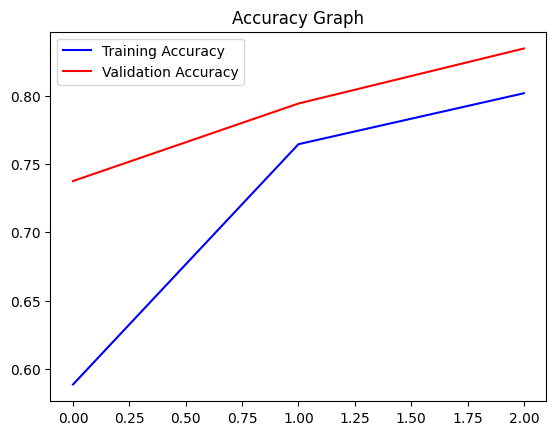

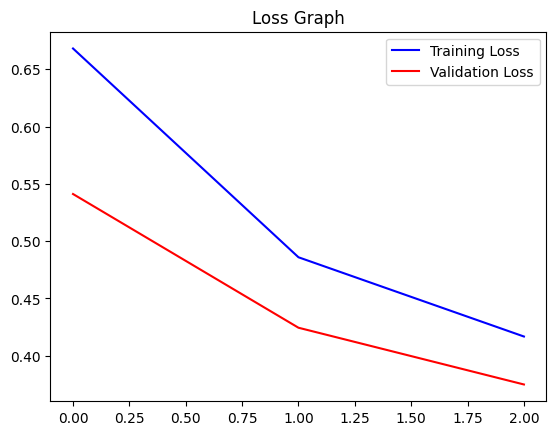

In [68]:
# Accuracy plot
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# Loss plot
loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


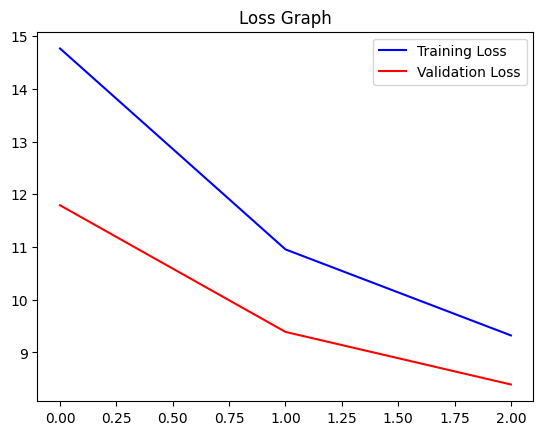

In [69]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


Testing

Original Gender: Female Original Age: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted Gender: Female Predicted Age: 24


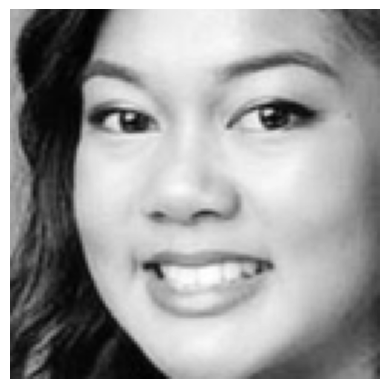

In [70]:
image_index = 555
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');


In [76]:
model.save("age_detection_model.h5")
model.save_weights("age_detection.weights.h5")


In [77]:
import os

print(os.listdir())


['FRM.keras', '.virtual_documents', 'age_detection_model.h5', 'model.png', 'age_detection.weights.h5']


In [80]:
from keras.models import load_model

model_loaded = load_model("age_detection_model.h5", compile=False)
model_loaded.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 126, 126, 32)   │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 63, 63, 32)     │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 30, 30, 64)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 14, 14, 128)    │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 12, 12, 256)    │        295,168 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 6, 6, 256)      │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 9216)           │              0 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │      2,359,552 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │      2,359,552 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 256)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 256)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_out (Dense)        │ (None, 1)              │            257 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_out (Dense)           │ (None, 1)              │            257 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_gender, y_test_gender = train_test_split(
    X, y_gender, test_size=0.2, random_state=42
)


In [89]:

y_pred_outputs = model.predict(X_test)
y_pred_gender = np.argmax(y_pred_outputs[0], axis=1)


y_true_gender = y_test_gender


from sklearn.metrics import confusion_matrix, precision_score, recall_score

cm = confusion_matrix(y_true_gender, y_pred_gender)
precision = precision_score(y_true_gender, y_pred_gender, average='binary')
recall = recall_score(y_true_gender, y_pred_gender, average='binary')


print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall:", recall)


149/149 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step
Confusion Matrix:
 [[2500    0]
 [2242    0]]
Precision: 0.0
Recall: 0.0
